In [1]:
import torch
import data
import tqdm
import models
import numpy as np
import json
import rcan
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Loading the configuration file, which contains information about the simulated images, and the telescopes they were modelled on, and some model hyperparameters

In [2]:
with open('../config.json') as config_file:
    config = json.load(config_file)

In [3]:
EPOCHS = 250
LR = 1e-6
IN_SHAPE = config["image_shape_2"] # image dimensions in pixels (assuming square image)
MAGNIFICATION = config["magnification"] # magnitude of each magnification
N_MAG = config["n_magnification"] # number of magnifications required to be performed
DELTA = config["resolution_3"] # LR image resolution
alpha_t_scaling = config["alpha_t_scaling"] # scaling coefficient of the tangential component of the deflection angle 
VDL_WEIGHT = 0.5 # initial vdl weight

### Scaling the deflection angle obtained from the SISR models:
The deflection angle values are obtained by design as $\alpha(x,y) \in (0,1)$. They are thus rescaled within appropriate bounds before their use for the purpose of lensing. The coefficients 1 and 2 correspond to the radial $\alpha_r(x,y)$ and tangential $\alpha_t(x,y)$ components of the deflection angle. While $\alpha_r(x,y)$ can ideally be used to contain all the pertaining information, this is no longer required ot be true, as the image space is discretized to pixels. To account for potential inaccuracies brought by this discretization, a (smaller) $\alpha_t(x,y)$ is used for the purpose of potential correction.

In [ ]:
alpha_bounds = [config["alpha_l"],config["alpha_h"]] # bounds for the deflection angle, used in it's scaling

alpha_coeff_1 = torch.tensor(alpha_bounds[1]-alpha_bounds[0]).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_coeff_2 = torch.tensor((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_coeff = torch.concat([alpha_coeff_1, alpha_coeff_2],dim=1)

alpha_disp_1 = torch.tensor(alpha_bounds[0]).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_disp_2 = torch.tensor(-((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling)/2).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_disp = torch.concat([alpha_disp_1, alpha_disp_2],dim=1)

def alpha_scaling(alpha):
    """
    Scales the deflection angle obtained from the model to meaningful bounds
    
    :param alpha: Deflection angle to be scaled
    :return: Scaled deflection angle
    """
    alpha = alpha * alpha_coeff.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    alpha = alpha + alpha_disp.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    return alpha

### Loading the datasets, the dataloaders and performing the required train:validation partitions
A batch size of 5 (merely for computational convenience) is used 5000 images for training, which is divided by an 80:20 validation split. The 5000 images are derived more-or-less equally from the three DM sub-structure classes. There are no high-resolution images loaded as they are not needed !

In [4]:
# We can now load the datasets, combine and shuffle them to have a (close to) homogenous distribution of all sub-structures.
BATCH_SIZE = 5 # Feel free to increase this number; all the training was done on my personal machine, hence, this limitation/

dataset_no_sub = data.LensingDataset('../../Simulations/data_model_3/',['no_sub'],5000)
train_dataset_no_sub, val_dataset_no_sub = torch.utils.data.random_split(dataset_no_sub, [0.8, 0.2])

dataset_axion = data.LensingDataset('../../Simulations/data_model_3/',['axion'],5000)
train_dataset_axion, val_dataset_axion = torch.utils.data.random_split(dataset_axion, [0.8, 0.2])

dataset_cdm = data.LensingDataset('../../Simulations/data_model_3/',['cdm'],5000)
train_dataset_cdm, val_dataset_cdm = torch.utils.data.random_split(dataset_cdm, [0.8, 0.2])

train_dataset = torch.utils.data.ConcatDataset([train_dataset_no_sub, train_dataset_axion, train_dataset_cdm])
val_dataset = torch.utils.data.ConcatDataset([val_dataset_no_sub, val_dataset_axion, val_dataset_cdm])

train_dataset, train_rest = torch.utils.data.random_split(train_dataset, [0.34, 0.66])
val_dataset, val_rest = torch.utils.data.random_split(val_dataset, [0.34, 0.66])

train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)
val_dataloader = torch.utils.data.DataLoader(val_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)

# This configuration will load 5000 (low-resolution) images in total, with a 80:20 validation split. 

### Model and physics-inspired loss function loading

In [5]:
# We construct and load the SISR model to the GPU (if available). A loss module is also loaded that performs all the operations required during training.

alpha_model = alpha_model = rcan.RCAN(scale=2, latent_dim=128, num_rg=2, num_rcab=2, reduction=2, out_channels=2).to(device).to(device)
lens_loss = models.SersicProfiler(resolution=DELTA, device=device, sersic_args = [1, 1, 0.25], vdl_weight=VDL_WEIGHT)

opt = torch.optim.Adam(params=alpha_model.parameters(),lr=LR)
alpha_params = sum(p.numel() for p in alpha_model.parameters())
print(f"Image network parameters: {alpha_params}")

Image network parameters: 2283650


### Performing weight initialization
Several studies have shown that model weight initialization can help in more effective convergence.

In [6]:
# Performing He initialization of the model weights.

def init_weights(m):
    """
    Iterates through all the convolution and fully connected layers of the model to initialize all their weights

    :param m: Model to be initialized
    """
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)  # He initialization
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

alpha_model.apply(init_weights)

RCAN(
  (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (rgs): Sequential(
    (0): RG(
      (rg): Sequential(
        (0): RCAB(
          (rcab): Sequential(
            (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): ReLU(inplace=True)
            (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (3): ChannelAttention(
              (attention): Sequential(
                (0): AdaptiveAvgPool2d(output_size=1)
                (1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
                (2): ReLU(inplace=True)
                (3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
                (4): Sigmoid()
              )
            )
          )
        )
        (1): RCAB(
          (rcab): Sequential(
            (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): ReLU(inplace=True)
            (2): Conv2d(128, 128, kerne

### Defining functions that sample the model's performance

In [7]:
def give_random_image(dataset, alpha_model, length, i=None, plot=True):
    """
    Provides a random image for evaluation

    :param dataset: Dataset used
    :param alpha_model: Model used
    :param length: Length of dataset used
    :param i: Index of the selected image, default: 
    :param plot: If true, also plots the source fitting graphs
    :return: original LR image, SR image, reconstructed source
    """
    if i == None:
        i = np.random.randint(low=0,high=length)
    LR = dataset[i].view(1,1,IN_SHAPE,IN_SHAPE).float()
    alpha = alpha_scaling(alpha_model(LR.float().to(device)).detach())
    sersic_profile, LR, source_profile = lens_loss.get_sample(alpha.to(device), LR.to(device), plot)
    LR_im = Image.fromarray(LR.cpu().detach().numpy()[0]*255)
    sersic_im = Image.fromarray(sersic_profile.cpu().detach().numpy()[0]*255)
    source_im = Image.fromarray(source_profile.cpu().detach().numpy()[0]*255)
    return (LR_im, sersic_im, source_im)

def show_random_image(image_tuple):
    """
    Displays the images provided by the give_random_image function
    
    :param image_tuple: Tuple of images returned by the give_random_image function
    """
    LR_im, sersic_im, source_im = image_tuple[0], image_tuple[1], image_tuple[2]
    plot, axes = plt.subplots(1,3)
    plot.set_size_inches(18,6)
    axes[0].imshow(LR_im)
    axes[1].imshow(sersic_im)
    axes[2].imshow(source_im)
    axes[0].set_title("LR_interpolated")
    axes[1].set_title("Image")
    axes[2].set_title("Source Profile")

/home/ashankar/Documents/Work/.env/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


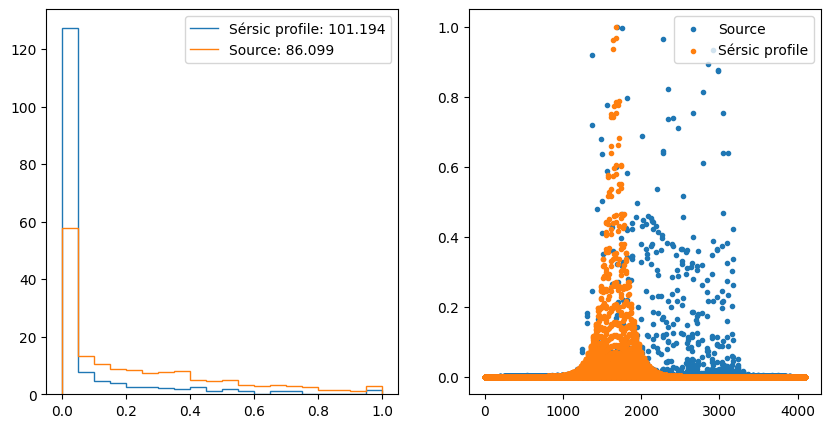

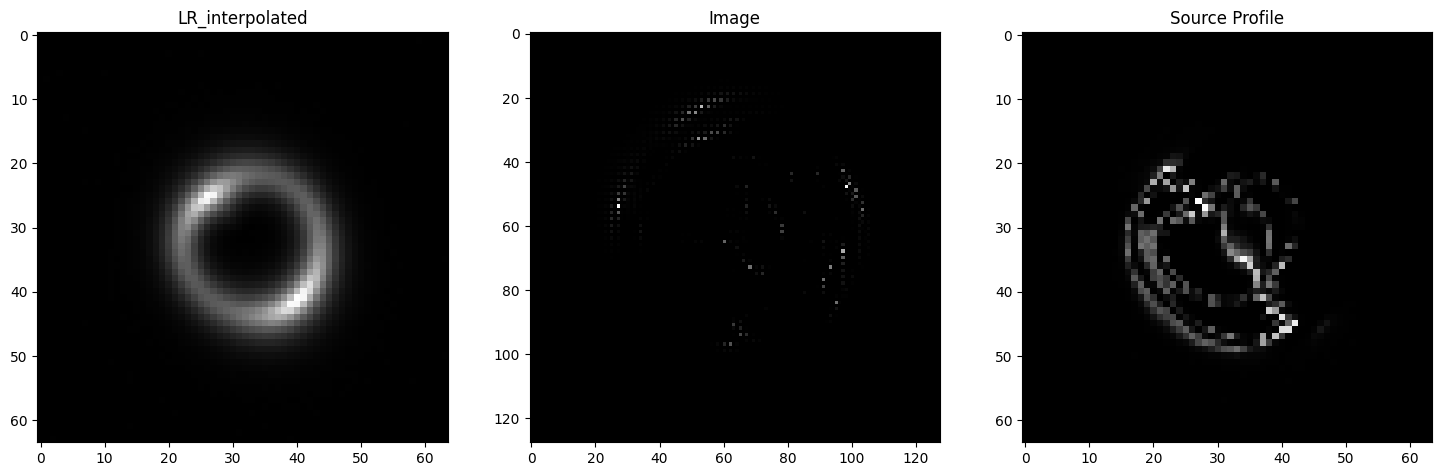

In [8]:
show_random_image(give_random_image(val_dataset, alpha_model, len(val_dataset)))

### The training sequence
The model is trained over the set number of epochs over the training images, and subsequently validated on the validation set. For both, the deflection angle given by the model is used to perform lensing, and is trained in an unsupervised manner by imposing the lensing system's constraints. Since the loss module is composed of various components, each of them is tracked for further study if required. In addition, the training process is stored as GIFs of the SR images, the LR images, and the reconstructed source.

In [9]:
# Training Sequence

best_val_loss = np.inf
best_weights = None
history = {'pre_loss':[],'val_loss':[], 'loss':[], 'images':[], 'lr':[], 'source':[]} # tracks the train and val losses and training results at each epoch
history_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]} # tracks the individual train loss components at each epoch
for epoch in range(EPOCHS):
    losses = []
    alpha_model.train()
    individual_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]}
    for i,(x) in enumerate(tqdm.tqdm(train_dataloader, desc=f"Training epoch {epoch+1}")):
        (x) = (x.float().to(device))
        alpha = alpha_model(x)
        alpha = alpha_scaling(alpha)
        loss, history_individual = lens_loss(alpha, x)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(float(loss))
        for key in individual_losses.keys():
            if history_individual[key] != None:
                individual_losses[key].append(float(history_individual[key]))
            else:
                individual_losses[key].append(None)
    for key in individual_losses.keys():
        if individual_losses[key][-1] != None:
            history_losses[key].append(np.mean(individual_losses[key]))
        else:
            history_losses[key].append(None)
    if np.isnan(losses[-1]): 
        break
    print(f"Training at epoch {epoch+1}/{EPOCHS}: {np.mean(losses) - float(np.mean(individual_losses['alpha_0']))} at LR={opt.param_groups[0]['lr']}")
    history['loss'].append(np.mean(losses) - float(np.mean(individual_losses['alpha_0'])))
    alpha_model.eval()
    individual_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]}
    losses = []
    for i,(x) in enumerate(tqdm.tqdm(val_dataloader, desc=f"Validation epoch {epoch+1}")):
        (x) = (x.float().to(device))
        alpha = alpha_scaling(alpha_model(x))
        val_loss, history_individual = lens_loss(alpha, x)
        losses.append(float(val_loss))
        for key in individual_losses.keys():
            if history_individual[key] != None:
                individual_losses[key].append(float(history_individual[key]))
            else:
                individual_losses[key].append(None)
    if best_val_loss > np.mean(losses) and np.mean(losses) != np.nan:
        best_val_loss = np.mean(losses)
        best_weights = alpha_model.state_dict()
    history['val_loss'].append(np.mean(losses) - float(np.mean(individual_losses['alpha_0'])))
    print(f"Validation at epoch {epoch+1}/{EPOCHS}: {np.mean(losses) - float(np.mean(individual_losses['alpha_0']))} at LR={opt.param_groups[0]['lr']}")
    lr, im, sr = give_random_image(val_dataset, alpha_model, len(val_dataset),50, plot=False)
    history['lr'].append(lr)
    history['images'].append(im)
    history['source'].append(sr)

Training epoch 1: 100%|██████████| 816/816 [01:05<00:00, 12.42it/s]


Training at epoch 1/250: 0.03236238380857537 at LR=1e-06


Validation epoch 1: 100%|██████████| 204/204 [00:06<00:00, 31.53it/s]


Validation at epoch 1/250: 0.028733094533284542 at LR=1e-06


Training epoch 2: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 2/250: 0.024009750133343832 at LR=1e-06


Validation epoch 2: 100%|██████████| 204/204 [00:06<00:00, 31.38it/s]


Validation at epoch 2/250: 0.021164107994706027 at LR=1e-06


Training epoch 3: 100%|██████████| 816/816 [01:05<00:00, 12.46it/s]


Training at epoch 3/250: 0.022103248383192498 at LR=1e-06


Validation epoch 3: 100%|██████████| 204/204 [00:06<00:00, 31.67it/s]


Validation at epoch 3/250: 0.022759895698696964 at LR=1e-06


Training epoch 4: 100%|██████████| 816/816 [01:05<00:00, 12.44it/s]


Training at epoch 4/250: 0.020821456815682204 at LR=1e-06


Validation epoch 4: 100%|██████████| 204/204 [00:06<00:00, 32.06it/s]


Validation at epoch 4/250: 0.021297570829298007 at LR=1e-06


Training epoch 5: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 5/250: 0.020592517895149265 at LR=1e-06


Validation epoch 5: 100%|██████████| 204/204 [00:06<00:00, 31.81it/s]


Validation at epoch 5/250: 0.01950338964953141 at LR=1e-06


Training epoch 6: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 6/250: 0.019580459350026114 at LR=1e-06


Validation epoch 6: 100%|██████████| 204/204 [00:06<00:00, 31.64it/s]


Validation at epoch 6/250: 0.02108946632520825 at LR=1e-06


Training epoch 7: 100%|██████████| 816/816 [01:05<00:00, 12.46it/s]


Training at epoch 7/250: 0.019035845355806408 at LR=1e-06


Validation epoch 7: 100%|██████████| 204/204 [00:06<00:00, 31.51it/s]


Validation at epoch 7/250: 0.019041407342050592 at LR=1e-06


Training epoch 8: 100%|██████████| 816/816 [01:05<00:00, 12.48it/s]


Training at epoch 8/250: 0.017471985179273536 at LR=1e-06


Validation epoch 8: 100%|██████████| 204/204 [00:06<00:00, 31.44it/s]


Validation at epoch 8/250: 0.01676980603267164 at LR=1e-06


Training epoch 9: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 9/250: 0.015576497688159052 at LR=1e-06


Validation epoch 9: 100%|██████████| 204/204 [00:06<00:00, 31.82it/s]


Validation at epoch 9/250: 0.013362187746108728 at LR=1e-06


Training epoch 10: 100%|██████████| 816/816 [01:05<00:00, 12.46it/s]


Training at epoch 10/250: 0.013696693048319386 at LR=1e-06


Validation epoch 10: 100%|██████████| 204/204 [00:06<00:00, 31.90it/s]


Validation at epoch 10/250: 0.013652664189245212 at LR=1e-06


Training epoch 11: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 11/250: 0.013067294058262124 at LR=1e-06


Validation epoch 11: 100%|██████████| 204/204 [00:06<00:00, 32.02it/s]


Validation at epoch 11/250: 0.01303778019021537 at LR=1e-06


Training epoch 12: 100%|██████████| 816/816 [01:05<00:00, 12.46it/s]


Training at epoch 12/250: 0.012454107002008191 at LR=1e-06


Validation epoch 12: 100%|██████████| 204/204 [00:06<00:00, 32.03it/s]


Validation at epoch 12/250: 0.0115421678432647 at LR=1e-06


Training epoch 13: 100%|██████████| 816/816 [01:05<00:00, 12.40it/s]


Training at epoch 13/250: 0.011384343491027182 at LR=1e-06


Validation epoch 13: 100%|██████████| 204/204 [00:06<00:00, 31.79it/s]


Validation at epoch 13/250: 0.010006031386700337 at LR=1e-06


Training epoch 14: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 14/250: 0.00965219099695483 at LR=1e-06


Validation epoch 14: 100%|██████████| 204/204 [00:06<00:00, 31.56it/s]


Validation at epoch 14/250: 0.00923993588224345 at LR=1e-06


Training epoch 15: 100%|██████████| 816/816 [01:05<00:00, 12.44it/s]


Training at epoch 15/250: 0.008924149972039691 at LR=1e-06


Validation epoch 15: 100%|██████████| 204/204 [00:06<00:00, 31.58it/s]


Validation at epoch 15/250: 0.008217677802723977 at LR=1e-06


Training epoch 16: 100%|██████████| 816/816 [01:05<00:00, 12.44it/s]


Training at epoch 16/250: 0.008420986150774898 at LR=1e-06


Validation epoch 16: 100%|██████████| 204/204 [00:06<00:00, 31.83it/s]


Validation at epoch 16/250: 0.008543552429068318 at LR=1e-06


Training epoch 17: 100%|██████████| 816/816 [01:05<00:00, 12.44it/s]


Training at epoch 17/250: 0.00812434140300633 at LR=1e-06


Validation epoch 17: 100%|██████████| 204/204 [00:06<00:00, 32.09it/s]


Validation at epoch 17/250: 0.008153778190414115 at LR=1e-06


Training epoch 18: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 18/250: 0.007896737862086181 at LR=1e-06


Validation epoch 18: 100%|██████████| 204/204 [00:06<00:00, 31.81it/s]


Validation at epoch 18/250: 0.007592032389605735 at LR=1e-06


Training epoch 19: 100%|██████████| 816/816 [01:05<00:00, 12.45it/s]


Training at epoch 19/250: 0.007731086382751953 at LR=1e-06


Validation epoch 19: 100%|██████████| 204/204 [00:06<00:00, 31.97it/s]


Validation at epoch 19/250: 0.007780761804942998 at LR=1e-06


Training epoch 20: 100%|██████████| 816/816 [01:05<00:00, 12.47it/s]


Training at epoch 20/250: 0.007620110340854705 at LR=1e-06


Validation epoch 20: 100%|██████████| 204/204 [00:06<00:00, 31.71it/s]


Validation at epoch 20/250: 0.007486516573265489 at LR=1e-06


Training epoch 21: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 21/250: 0.007531753960339463 at LR=1e-06


Validation epoch 21: 100%|██████████| 204/204 [00:06<00:00, 31.99it/s]


Validation at epoch 21/250: 0.00753637330204833 at LR=1e-06


Training epoch 22: 100%|██████████| 816/816 [01:05<00:00, 12.47it/s]


Training at epoch 22/250: 0.007469620382157607 at LR=1e-06


Validation epoch 22: 100%|██████████| 204/204 [00:06<00:00, 31.80it/s]


Validation at epoch 22/250: 0.007803136592402171 at LR=1e-06


Training epoch 23: 100%|██████████| 816/816 [01:05<00:00, 12.42it/s]


Training at epoch 23/250: 0.007351542421269647 at LR=1e-06


Validation epoch 23: 100%|██████████| 204/204 [00:06<00:00, 31.77it/s]


Validation at epoch 23/250: 0.007127039828429035 at LR=1e-06


Training epoch 24: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 24/250: 0.00730607844889164 at LR=1e-06


Validation epoch 24: 100%|██████████| 204/204 [00:06<00:00, 31.94it/s]


Validation at epoch 24/250: 0.007233789227172452 at LR=1e-06


Training epoch 25: 100%|██████████| 816/816 [01:05<00:00, 12.42it/s]


Training at epoch 25/250: 0.007209201197267742 at LR=1e-06


Validation epoch 25: 100%|██████████| 204/204 [00:06<00:00, 31.80it/s]


Validation at epoch 25/250: 0.007115646064573641 at LR=1e-06


Training epoch 26: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 26/250: 0.007129349590589598 at LR=1e-06


Validation epoch 26: 100%|██████████| 204/204 [00:06<00:00, 31.70it/s]


Validation at epoch 26/250: 0.00705869700394425 at LR=1e-06


Training epoch 27: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 27/250: 0.007023494078905554 at LR=1e-06


Validation epoch 27: 100%|██████████| 204/204 [00:06<00:00, 31.86it/s]


Validation at epoch 27/250: 0.0067942650879130595 at LR=1e-06


Training epoch 28: 100%|██████████| 816/816 [01:05<00:00, 12.44it/s]


Training at epoch 28/250: 0.006964038126170635 at LR=1e-06


Validation epoch 28: 100%|██████████| 204/204 [00:06<00:00, 31.21it/s]


Validation at epoch 28/250: 0.006851160497057668 at LR=1e-06


Training epoch 29: 100%|██████████| 816/816 [01:05<00:00, 12.44it/s]


Training at epoch 29/250: 0.006923957526975985 at LR=1e-06


Validation epoch 29: 100%|██████████| 204/204 [00:06<00:00, 31.82it/s]


Validation at epoch 29/250: 0.0069179972451107186 at LR=1e-06


Training epoch 30: 100%|██████████| 816/816 [01:05<00:00, 12.44it/s]


Training at epoch 30/250: 0.006890060151835867 at LR=1e-06


Validation epoch 30: 100%|██████████| 204/204 [00:06<00:00, 31.77it/s]


Validation at epoch 30/250: 0.006954733830164456 at LR=1e-06


Training epoch 31: 100%|██████████| 816/816 [01:05<00:00, 12.42it/s]


Training at epoch 31/250: 0.0067975538024934445 at LR=1e-06


Validation epoch 31: 100%|██████████| 204/204 [00:06<00:00, 31.25it/s]


Validation at epoch 31/250: 0.006754125048424681 at LR=1e-06


Training epoch 32: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 32/250: 0.006803439756599722 at LR=1e-06


Validation epoch 32: 100%|██████████| 204/204 [00:06<00:00, 32.00it/s]


Validation at epoch 32/250: 0.006561684276105151 at LR=1e-06


Training epoch 33: 100%|██████████| 816/816 [01:05<00:00, 12.45it/s]


Training at epoch 33/250: 0.006737048806184365 at LR=1e-06


Validation epoch 33: 100%|██████████| 204/204 [00:06<00:00, 31.58it/s]


Validation at epoch 33/250: 0.006436916780384147 at LR=1e-06


Training epoch 34: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 34/250: 0.0067335932661651415 at LR=1e-06


Validation epoch 34: 100%|██████████| 204/204 [00:06<00:00, 31.59it/s]


Validation at epoch 34/250: 0.0063509389246795694 at LR=1e-06


Training epoch 35: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 35/250: 0.006667833944198245 at LR=1e-06


Validation epoch 35: 100%|██████████| 204/204 [00:06<00:00, 31.76it/s]


Validation at epoch 35/250: 0.006615922055846338 at LR=1e-06


Training epoch 36: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 36/250: 0.006628427809725196 at LR=1e-06


Validation epoch 36: 100%|██████████| 204/204 [00:06<00:00, 31.67it/s]


Validation at epoch 36/250: 0.00646977146685708 at LR=1e-06


Training epoch 37: 100%|██████████| 816/816 [01:05<00:00, 12.37it/s]


Training at epoch 37/250: 0.006573805653983189 at LR=1e-06


Validation epoch 37: 100%|██████████| 204/204 [00:06<00:00, 31.21it/s]


Validation at epoch 37/250: 0.006561324566456625 at LR=1e-06


Training epoch 38: 100%|██████████| 816/816 [01:05<00:00, 12.42it/s]


Training at epoch 38/250: 0.0065455078284311075 at LR=1e-06


Validation epoch 38: 100%|██████████| 204/204 [00:06<00:00, 32.05it/s]


Validation at epoch 38/250: 0.006507721948711312 at LR=1e-06


Training epoch 39: 100%|██████████| 816/816 [01:05<00:00, 12.42it/s]


Training at epoch 39/250: 0.006507062166016181 at LR=1e-06


Validation epoch 39: 100%|██████████| 204/204 [00:06<00:00, 31.71it/s]


Validation at epoch 39/250: 0.006390482278577261 at LR=1e-06


Training epoch 40: 100%|██████████| 816/816 [01:05<00:00, 12.44it/s]


Training at epoch 40/250: 0.006451170608474346 at LR=1e-06


Validation epoch 40: 100%|██████████| 204/204 [00:06<00:00, 31.44it/s]


Validation at epoch 40/250: 0.006344579342825743 at LR=1e-06


Training epoch 41: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 41/250: 0.006442330841559402 at LR=1e-06


Validation epoch 41: 100%|██████████| 204/204 [00:06<00:00, 31.60it/s]


Validation at epoch 41/250: 0.006385163696227117 at LR=1e-06


Training epoch 42: 100%|██████████| 816/816 [01:05<00:00, 12.40it/s]


Training at epoch 42/250: 0.0063809501281117675 at LR=1e-06


Validation epoch 42: 100%|██████████| 204/204 [00:06<00:00, 31.94it/s]


Validation at epoch 42/250: 0.0062137563146797 at LR=1e-06


Training epoch 43: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 43/250: 0.006375986165093155 at LR=1e-06


Validation epoch 43: 100%|██████████| 204/204 [00:06<00:00, 31.77it/s]


Validation at epoch 43/250: 0.006136213867541623 at LR=1e-06


Training epoch 44: 100%|██████████| 816/816 [01:05<00:00, 12.39it/s]


Training at epoch 44/250: 0.00632416968252144 at LR=1e-06


Validation epoch 44: 100%|██████████| 204/204 [00:06<00:00, 31.61it/s]


Validation at epoch 44/250: 0.006232445858711126 at LR=1e-06


Training epoch 45: 100%|██████████| 816/816 [01:05<00:00, 12.39it/s]


Training at epoch 45/250: 0.006316045993099019 at LR=1e-06


Validation epoch 45: 100%|██████████| 204/204 [00:06<00:00, 31.53it/s]


Validation at epoch 45/250: 0.006377729258554829 at LR=1e-06


Training epoch 46: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 46/250: 0.006269256237382982 at LR=1e-06


Validation epoch 46: 100%|██████████| 204/204 [00:06<00:00, 31.99it/s]


Validation at epoch 46/250: 0.00598727369352299 at LR=1e-06


Training epoch 47: 100%|██████████| 816/816 [01:05<00:00, 12.42it/s]


Training at epoch 47/250: 0.006276152621699026 at LR=1e-06


Validation epoch 47: 100%|██████████| 204/204 [00:06<00:00, 31.52it/s]


Validation at epoch 47/250: 0.006235253358004136 at LR=1e-06


Training epoch 48: 100%|██████████| 816/816 [01:05<00:00, 12.38it/s]


Training at epoch 48/250: 0.006203268362464862 at LR=1e-06


Validation epoch 48: 100%|██████████| 204/204 [00:06<00:00, 31.89it/s]


Validation at epoch 48/250: 0.006211021714204672 at LR=1e-06


Training epoch 49: 100%|██████████| 816/816 [01:05<00:00, 12.39it/s]


Training at epoch 49/250: 0.0062257490148219935 at LR=1e-06


Validation epoch 49: 100%|██████████| 204/204 [00:06<00:00, 31.38it/s]


Validation at epoch 49/250: 0.006505674627773905 at LR=1e-06


Training epoch 50: 100%|██████████| 816/816 [01:05<00:00, 12.44it/s]


Training at epoch 50/250: 0.006216929737003704 at LR=1e-06


Validation epoch 50: 100%|██████████| 204/204 [00:06<00:00, 31.54it/s]


Validation at epoch 50/250: 0.006119735812877912 at LR=1e-06


Training epoch 51: 100%|██████████| 816/816 [01:05<00:00, 12.39it/s]


Training at epoch 51/250: 0.006129032598954504 at LR=1e-06


Validation epoch 51: 100%|██████████| 204/204 [00:06<00:00, 31.12it/s]


Validation at epoch 51/250: 0.005949872107628512 at LR=1e-06


Training epoch 52: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 52/250: 0.0061439180326666315 at LR=1e-06


Validation epoch 52: 100%|██████████| 204/204 [00:06<00:00, 31.60it/s]


Validation at epoch 52/250: 0.006036463449252585 at LR=1e-06


Training epoch 53: 100%|██████████| 816/816 [01:05<00:00, 12.38it/s]


Training at epoch 53/250: 0.006089514030107102 at LR=1e-06


Validation epoch 53: 100%|██████████| 204/204 [00:06<00:00, 31.47it/s]


Validation at epoch 53/250: 0.0059642935646515224 at LR=1e-06


Training epoch 54: 100%|██████████| 816/816 [01:05<00:00, 12.44it/s]


Training at epoch 54/250: 0.006102468069715823 at LR=1e-06


Validation epoch 54: 100%|██████████| 204/204 [00:06<00:00, 31.32it/s]


Validation at epoch 54/250: 0.006534305108966784 at LR=1e-06


Training epoch 55: 100%|██████████| 816/816 [01:05<00:00, 12.39it/s]


Training at epoch 55/250: 0.006098646428618647 at LR=1e-06


Validation epoch 55: 100%|██████████| 204/204 [00:06<00:00, 31.65it/s]


Validation at epoch 55/250: 0.005837726278924475 at LR=1e-06


Training epoch 56: 100%|██████████| 816/816 [01:05<00:00, 12.40it/s]


Training at epoch 56/250: 0.006068264563367058 at LR=1e-06


Validation epoch 56: 100%|██████████| 204/204 [00:06<00:00, 31.57it/s]


Validation at epoch 56/250: 0.005920336764378871 at LR=1e-06


Training epoch 57: 100%|██████████| 816/816 [01:05<00:00, 12.38it/s]


Training at epoch 57/250: 0.006114190129344076 at LR=1e-06


Validation epoch 57: 100%|██████████| 204/204 [00:06<00:00, 31.51it/s]


Validation at epoch 57/250: 0.005802513574998752 at LR=1e-06


Training epoch 58: 100%|██████████| 816/816 [01:05<00:00, 12.38it/s]


Training at epoch 58/250: 0.006036696156632965 at LR=1e-06


Validation epoch 58: 100%|██████████| 204/204 [00:06<00:00, 31.87it/s]


Validation at epoch 58/250: 0.0060221169910886704 at LR=1e-06


Training epoch 59: 100%|██████████| 816/816 [01:05<00:00, 12.42it/s]


Training at epoch 59/250: 0.006060757432315572 at LR=1e-06


Validation epoch 59: 100%|██████████| 204/204 [00:06<00:00, 31.43it/s]


Validation at epoch 59/250: 0.005928105674684048 at LR=1e-06


Training epoch 60: 100%|██████████| 816/816 [01:05<00:00, 12.38it/s]


Training at epoch 60/250: 0.006034332984948862 at LR=1e-06


Validation epoch 60: 100%|██████████| 204/204 [00:06<00:00, 31.85it/s]


Validation at epoch 60/250: 0.005924087985619608 at LR=1e-06


Training epoch 61: 100%|██████████| 816/816 [01:05<00:00, 12.38it/s]


Training at epoch 61/250: 0.00602501374669373 at LR=1e-06


Validation epoch 61: 100%|██████████| 204/204 [00:06<00:00, 31.81it/s]


Validation at epoch 61/250: 0.0060216678744729815 at LR=1e-06


Training epoch 62: 100%|██████████| 816/816 [01:05<00:00, 12.40it/s]


Training at epoch 62/250: 0.005976462933033999 at LR=1e-06


Validation epoch 62: 100%|██████████| 204/204 [00:06<00:00, 31.20it/s]


Validation at epoch 62/250: 0.006066159564344316 at LR=1e-06


Training epoch 63: 100%|██████████| 816/816 [01:05<00:00, 12.38it/s]


Training at epoch 63/250: 0.005994901321280527 at LR=1e-06


Validation epoch 63: 100%|██████████| 204/204 [00:06<00:00, 31.44it/s]


Validation at epoch 63/250: 0.005767388762358355 at LR=1e-06


Training epoch 64: 100%|██████████| 816/816 [01:05<00:00, 12.42it/s]


Training at epoch 64/250: 0.005924689304996643 at LR=1e-06


Validation epoch 64: 100%|██████████| 204/204 [00:06<00:00, 31.32it/s]


Validation at epoch 64/250: 0.005962484570987081 at LR=1e-06


Training epoch 65: 100%|██████████| 816/816 [01:05<00:00, 12.42it/s]


Training at epoch 65/250: 0.005924461190314853 at LR=1e-06


Validation epoch 65: 100%|██████████| 204/204 [00:06<00:00, 32.10it/s]


Validation at epoch 65/250: 0.006185130581405816 at LR=1e-06


Training epoch 66: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 66/250: 0.00592571240849793 at LR=1e-06


Validation epoch 66: 100%|██████████| 204/204 [00:06<00:00, 31.97it/s]


Validation at epoch 66/250: 0.006388242575613892 at LR=1e-06


Training epoch 67: 100%|██████████| 816/816 [01:05<00:00, 12.40it/s]


Training at epoch 67/250: 0.005910003749544125 at LR=1e-06


Validation epoch 67: 100%|██████████| 204/204 [00:06<00:00, 31.92it/s]


Validation at epoch 67/250: 0.005855058118993159 at LR=1e-06


Training epoch 68: 100%|██████████| 816/816 [01:05<00:00, 12.40it/s]


Training at epoch 68/250: 0.005860978801387785 at LR=1e-06


Validation epoch 68: 100%|██████████| 204/204 [00:06<00:00, 31.29it/s]


Validation at epoch 68/250: 0.005735310853696336 at LR=1e-06


Training epoch 69: 100%|██████████| 816/816 [01:05<00:00, 12.40it/s]


Training at epoch 69/250: 0.0058336308061638295 at LR=1e-06


Validation epoch 69: 100%|██████████| 204/204 [00:06<00:00, 31.71it/s]


Validation at epoch 69/250: 0.0056234004669914045 at LR=1e-06


Training epoch 70: 100%|██████████| 816/816 [01:05<00:00, 12.40it/s]


Training at epoch 70/250: 0.0058342767194570835 at LR=1e-06


Validation epoch 70: 100%|██████████| 204/204 [00:06<00:00, 31.37it/s]


Validation at epoch 70/250: 0.005691921794969662 at LR=1e-06


Training epoch 71: 100%|██████████| 816/816 [01:05<00:00, 12.38it/s]


Training at epoch 71/250: 0.005807939725106251 at LR=1e-06


Validation epoch 71: 100%|██████████| 204/204 [00:06<00:00, 31.57it/s]


Validation at epoch 71/250: 0.005666252572600748 at LR=1e-06


Training epoch 72: 100%|██████████| 816/816 [01:05<00:00, 12.38it/s]


Training at epoch 72/250: 0.005763607880319745 at LR=1e-06


Validation epoch 72: 100%|██████████| 204/204 [00:06<00:00, 31.49it/s]


Validation at epoch 72/250: 0.00553487537100035 at LR=1e-06


Training epoch 73: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 73/250: 0.0057448500256035845 at LR=1e-06


Validation epoch 73: 100%|██████████| 204/204 [00:06<00:00, 31.68it/s]


Validation at epoch 73/250: 0.005810896080790787 at LR=1e-06


Training epoch 74: 100%|██████████| 816/816 [01:05<00:00, 12.40it/s]


Training at epoch 74/250: 0.005724699971466962 at LR=1e-06


Validation epoch 74: 100%|██████████| 204/204 [00:06<00:00, 31.79it/s]


Validation at epoch 74/250: 0.005532050724415219 at LR=1e-06


Training epoch 75: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 75/250: 0.00567943280489714 at LR=1e-06


Validation epoch 75: 100%|██████████| 204/204 [00:06<00:00, 31.39it/s]


Validation at epoch 75/250: 0.00550550830495708 at LR=1e-06


Training epoch 76: 100%|██████████| 816/816 [01:05<00:00, 12.42it/s]


Training at epoch 76/250: 0.005653753091453335 at LR=1e-06


Validation epoch 76: 100%|██████████| 204/204 [00:06<00:00, 31.65it/s]


Validation at epoch 76/250: 0.0057689167887848974 at LR=1e-06


Training epoch 77: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 77/250: 0.005616153526466848 at LR=1e-06


Validation epoch 77: 100%|██████████| 204/204 [00:06<00:00, 31.49it/s]


Validation at epoch 77/250: 0.005481625907123089 at LR=1e-06


Training epoch 78: 100%|██████████| 816/816 [01:05<00:00, 12.36it/s]


Training at epoch 78/250: 0.005627555448525383 at LR=1e-06


Validation epoch 78: 100%|██████████| 204/204 [00:06<00:00, 31.39it/s]


Validation at epoch 78/250: 0.005785543051566568 at LR=1e-06


Training epoch 79: 100%|██████████| 816/816 [01:05<00:00, 12.38it/s]


Training at epoch 79/250: 0.005606667754952527 at LR=1e-06


Validation epoch 79: 100%|██████████| 204/204 [00:06<00:00, 31.60it/s]


Validation at epoch 79/250: 0.005303606719655143 at LR=1e-06


Training epoch 80: 100%|██████████| 816/816 [01:05<00:00, 12.37it/s]


Training at epoch 80/250: 0.005519023315761894 at LR=1e-06


Validation epoch 80: 100%|██████████| 204/204 [00:06<00:00, 31.60it/s]


Validation at epoch 80/250: 0.005346470147225203 at LR=1e-06


Training epoch 81: 100%|██████████| 816/816 [01:05<00:00, 12.42it/s]


Training at epoch 81/250: 0.00551292954661025 at LR=1e-06


Validation epoch 81: 100%|██████████| 204/204 [00:06<00:00, 31.93it/s]


Validation at epoch 81/250: 0.00541399895012671 at LR=1e-06


Training epoch 82: 100%|██████████| 816/816 [01:06<00:00, 12.36it/s]


Training at epoch 82/250: 0.005448149314022384 at LR=1e-06


Validation epoch 82: 100%|██████████| 204/204 [00:06<00:00, 31.65it/s]


Validation at epoch 82/250: 0.005368796359820689 at LR=1e-06


Training epoch 83: 100%|██████████| 816/816 [01:05<00:00, 12.38it/s]


Training at epoch 83/250: 0.00540469755537297 at LR=1e-06


Validation epoch 83: 100%|██████████| 204/204 [00:06<00:00, 32.16it/s]


Validation at epoch 83/250: 0.005378273516601209 at LR=1e-06


Training epoch 84: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 84/250: 0.005397439212994834 at LR=1e-06


Validation epoch 84: 100%|██████████| 204/204 [00:06<00:00, 31.56it/s]


Validation at epoch 84/250: 0.005292945450135304 at LR=1e-06


Training epoch 85: 100%|██████████| 816/816 [01:05<00:00, 12.44it/s]


Training at epoch 85/250: 0.005392237600651301 at LR=1e-06


Validation epoch 85: 100%|██████████| 204/204 [00:06<00:00, 31.45it/s]


Validation at epoch 85/250: 0.005208956242045933 at LR=1e-06


Training epoch 86: 100%|██████████| 816/816 [01:05<00:00, 12.38it/s]


Training at epoch 86/250: 0.005353926014447327 at LR=1e-06


Validation epoch 86: 100%|██████████| 204/204 [00:06<00:00, 31.73it/s]


Validation at epoch 86/250: 0.0050917169280058 at LR=1e-06


Training epoch 87: 100%|██████████| 816/816 [01:05<00:00, 12.42it/s]


Training at epoch 87/250: 0.005322136749586495 at LR=1e-06


Validation epoch 87: 100%|██████████| 204/204 [00:06<00:00, 31.87it/s]


Validation at epoch 87/250: 0.005434843629379488 at LR=1e-06


Training epoch 88: 100%|██████████| 816/816 [01:05<00:00, 12.45it/s]


Training at epoch 88/250: 0.0053017319787257156 at LR=1e-06


Validation epoch 88: 100%|██████████| 204/204 [00:06<00:00, 31.45it/s]


Validation at epoch 88/250: 0.005420849375499817 at LR=1e-06


Training epoch 89: 100%|██████████| 816/816 [01:05<00:00, 12.39it/s]


Training at epoch 89/250: 0.0052774463501740615 at LR=1e-06


Validation epoch 89: 100%|██████████| 204/204 [00:06<00:00, 31.78it/s]


Validation at epoch 89/250: 0.005715153107017867 at LR=1e-06


Training epoch 90: 100%|██████████| 816/816 [01:05<00:00, 12.39it/s]


Training at epoch 90/250: 0.0052299579199147905 at LR=1e-06


Validation epoch 90: 100%|██████████| 204/204 [00:06<00:00, 31.66it/s]


Validation at epoch 90/250: 0.00507898495404744 at LR=1e-06


Training epoch 91: 100%|██████████| 816/816 [01:05<00:00, 12.39it/s]


Training at epoch 91/250: 0.005198059576180046 at LR=1e-06


Validation epoch 91: 100%|██████████| 204/204 [00:06<00:00, 31.72it/s]


Validation at epoch 91/250: 0.0052450905079204704 at LR=1e-06


Training epoch 92: 100%|██████████| 816/816 [01:05<00:00, 12.40it/s]


Training at epoch 92/250: 0.005194983011403795 at LR=1e-06


Validation epoch 92: 100%|██████████| 204/204 [00:06<00:00, 32.04it/s]


Validation at epoch 92/250: 0.005025436791280903 at LR=1e-06


Training epoch 93: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 93/250: 0.00511378303224988 at LR=1e-06


Validation epoch 93: 100%|██████████| 204/204 [00:06<00:00, 31.76it/s]


Validation at epoch 93/250: 0.00502326919277217 at LR=1e-06


Training epoch 94: 100%|██████████| 816/816 [01:05<00:00, 12.40it/s]


Training at epoch 94/250: 0.005117163525474276 at LR=1e-06


Validation epoch 94: 100%|██████████| 204/204 [00:06<00:00, 31.75it/s]


Validation at epoch 94/250: 0.005308034144999349 at LR=1e-06


Training epoch 95: 100%|██████████| 816/816 [01:05<00:00, 12.42it/s]


Training at epoch 95/250: 0.005051102135421745 at LR=1e-06


Validation epoch 95: 100%|██████████| 204/204 [00:06<00:00, 31.56it/s]


Validation at epoch 95/250: 0.004990401586481168 at LR=1e-06


Training epoch 96: 100%|██████████| 816/816 [01:05<00:00, 12.40it/s]


Training at epoch 96/250: 0.005044395446448642 at LR=1e-06


Validation epoch 96: 100%|██████████| 204/204 [00:06<00:00, 31.68it/s]


Validation at epoch 96/250: 0.0049622604787787974 at LR=1e-06


Training epoch 97: 100%|██████████| 816/816 [01:05<00:00, 12.39it/s]


Training at epoch 97/250: 0.005004178221319239 at LR=1e-06


Validation epoch 97: 100%|██████████| 204/204 [00:06<00:00, 31.96it/s]


Validation at epoch 97/250: 0.004813393924896624 at LR=1e-06


Training epoch 98: 100%|██████████| 816/816 [01:05<00:00, 12.42it/s]


Training at epoch 98/250: 0.004994532693743559 at LR=1e-06


Validation epoch 98: 100%|██████████| 204/204 [00:06<00:00, 31.56it/s]


Validation at epoch 98/250: 0.005027375914448615 at LR=1e-06


Training epoch 99: 100%|██████████| 816/816 [01:05<00:00, 12.44it/s]


Training at epoch 99/250: 0.004955768452811184 at LR=1e-06


Validation epoch 99: 100%|██████████| 204/204 [00:06<00:00, 31.64it/s]


Validation at epoch 99/250: 0.004749609632234947 at LR=1e-06


Training epoch 100: 100%|██████████| 816/816 [01:05<00:00, 12.44it/s]


Training at epoch 100/250: 0.004917812239214336 at LR=1e-06


Validation epoch 100: 100%|██████████| 204/204 [00:06<00:00, 30.88it/s]


Validation at epoch 100/250: 0.00483817621773365 at LR=1e-06


Training epoch 101: 100%|██████████| 816/816 [01:05<00:00, 12.40it/s]


Training at epoch 101/250: 0.004879536570561137 at LR=1e-06


Validation epoch 101: 100%|██████████| 204/204 [00:06<00:00, 31.69it/s]


Validation at epoch 101/250: 0.005005698769773338 at LR=1e-06


Training epoch 102: 100%|██████████| 816/816 [01:05<00:00, 12.44it/s]


Training at epoch 102/250: 0.004845594800095637 at LR=1e-06


Validation epoch 102: 100%|██████████| 204/204 [00:06<00:00, 31.68it/s]


Validation at epoch 102/250: 0.0049663191369059 at LR=1e-06


Training epoch 103: 100%|██████████| 816/816 [01:05<00:00, 12.36it/s]


Training at epoch 103/250: 0.0048279202264715285 at LR=1e-06


Validation epoch 103: 100%|██████████| 204/204 [00:06<00:00, 31.79it/s]


Validation at epoch 103/250: 0.004744941350437848 at LR=1e-06


Training epoch 104: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 104/250: 0.004786768204569088 at LR=1e-06


Validation epoch 104: 100%|██████████| 204/204 [00:06<00:00, 31.37it/s]


Validation at epoch 104/250: 0.0048414484469913935 at LR=1e-06


Training epoch 105: 100%|██████████| 816/816 [01:05<00:00, 12.40it/s]


Training at epoch 105/250: 0.004742368338994829 at LR=1e-06


Validation epoch 105: 100%|██████████| 204/204 [00:06<00:00, 31.97it/s]


Validation at epoch 105/250: 0.004807172626183902 at LR=1e-06


Training epoch 106: 100%|██████████| 816/816 [01:05<00:00, 12.42it/s]


Training at epoch 106/250: 0.004705902031513255 at LR=1e-06


Validation epoch 106: 100%|██████████| 204/204 [00:06<00:00, 31.45it/s]


Validation at epoch 106/250: 0.004610527507668619 at LR=1e-06


Training epoch 107: 100%|██████████| 816/816 [01:05<00:00, 12.40it/s]


Training at epoch 107/250: 0.004681240048204714 at LR=1e-06


Validation epoch 107: 100%|██████████| 204/204 [00:06<00:00, 31.26it/s]


Validation at epoch 107/250: 0.004665440943676467 at LR=1e-06


Training epoch 108: 100%|██████████| 816/816 [01:05<00:00, 12.42it/s]


Training at epoch 108/250: 0.004623669870745611 at LR=1e-06


Validation epoch 108: 100%|██████████| 204/204 [00:06<00:00, 31.55it/s]


Validation at epoch 108/250: 0.004828957174265503 at LR=1e-06


Training epoch 109: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 109/250: 0.004577261167487093 at LR=1e-06


Validation epoch 109: 100%|██████████| 204/204 [00:06<00:00, 31.54it/s]


Validation at epoch 109/250: 0.00490454617230331 at LR=1e-06


Training epoch 110: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 110/250: 0.0045544408015249435 at LR=1e-06


Validation epoch 110: 100%|██████████| 204/204 [00:06<00:00, 31.78it/s]


Validation at epoch 110/250: 0.004518574121974265 at LR=1e-06


Training epoch 111: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 111/250: 0.004501213534169046 at LR=1e-06


Validation epoch 111: 100%|██████████| 204/204 [00:06<00:00, 31.62it/s]


Validation at epoch 111/250: 0.004490252027251555 at LR=1e-06


Training epoch 112: 100%|██████████| 816/816 [01:05<00:00, 12.38it/s]


Training at epoch 112/250: 0.004482850836425582 at LR=1e-06


Validation epoch 112: 100%|██████████| 204/204 [00:06<00:00, 31.64it/s]


Validation at epoch 112/250: 0.004552456002463318 at LR=1e-06


Training epoch 113: 100%|██████████| 816/816 [01:05<00:00, 12.40it/s]


Training at epoch 113/250: 0.0044213536231979475 at LR=1e-06


Validation epoch 113: 100%|██████████| 204/204 [00:06<00:00, 31.89it/s]


Validation at epoch 113/250: 0.004466448545309844 at LR=1e-06


Training epoch 114: 100%|██████████| 816/816 [01:05<00:00, 12.45it/s]


Training at epoch 114/250: 0.004435567746815434 at LR=1e-06


Validation epoch 114: 100%|██████████| 204/204 [00:06<00:00, 31.48it/s]


Validation at epoch 114/250: 0.004349675969969411 at LR=1e-06


Training epoch 115: 100%|██████████| 816/816 [01:05<00:00, 12.38it/s]


Training at epoch 115/250: 0.004339158491633244 at LR=1e-06


Validation epoch 115: 100%|██████████| 204/204 [00:06<00:00, 32.00it/s]


Validation at epoch 115/250: 0.004414894572440899 at LR=1e-06


Training epoch 116: 100%|██████████| 816/816 [01:05<00:00, 12.42it/s]


Training at epoch 116/250: 0.004335464208898153 at LR=1e-06


Validation epoch 116: 100%|██████████| 204/204 [00:06<00:00, 31.62it/s]


Validation at epoch 116/250: 0.004395257005942805 at LR=1e-06


Training epoch 117: 100%|██████████| 816/816 [01:05<00:00, 12.42it/s]


Training at epoch 117/250: 0.004265921290817799 at LR=1e-06


Validation epoch 117: 100%|██████████| 204/204 [00:06<00:00, 31.81it/s]


Validation at epoch 117/250: 0.004277051654735617 at LR=1e-06


Training epoch 118: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 118/250: 0.004239627116761516 at LR=1e-06


Validation epoch 118: 100%|██████████| 204/204 [00:06<00:00, 31.69it/s]


Validation at epoch 118/250: 0.004192595461419986 at LR=1e-06


Training epoch 119: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 119/250: 0.004241770599037409 at LR=1e-06


Validation epoch 119: 100%|██████████| 204/204 [00:06<00:00, 31.66it/s]


Validation at epoch 119/250: 0.004413743101644753 at LR=1e-06


Training epoch 120: 100%|██████████| 816/816 [01:05<00:00, 12.40it/s]


Training at epoch 120/250: 0.0042126547778025235 at LR=1e-06


Validation epoch 120: 100%|██████████| 204/204 [00:06<00:00, 31.96it/s]


Validation at epoch 120/250: 0.004234797449088563 at LR=1e-06


Training epoch 121: 100%|██████████| 816/816 [01:05<00:00, 12.39it/s]


Training at epoch 121/250: 0.0041660766788374805 at LR=1e-06


Validation epoch 121: 100%|██████████| 204/204 [00:06<00:00, 31.42it/s]


Validation at epoch 121/250: 0.004273584678623023 at LR=1e-06


Training epoch 122: 100%|██████████| 816/816 [01:05<00:00, 12.45it/s]


Training at epoch 122/250: 0.004112699546157294 at LR=1e-06


Validation epoch 122: 100%|██████████| 204/204 [00:06<00:00, 31.78it/s]


Validation at epoch 122/250: 0.00411718002721375 at LR=1e-06


Training epoch 123: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 123/250: 0.0041003689379887805 at LR=1e-06


Validation epoch 123: 100%|██████████| 204/204 [00:06<00:00, 31.48it/s]


Validation at epoch 123/250: 0.004055017806297422 at LR=1e-06


Training epoch 124: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 124/250: 0.004039658012105995 at LR=1e-06


Validation epoch 124: 100%|██████████| 204/204 [00:06<00:00, 31.70it/s]


Validation at epoch 124/250: 0.0041140955781527565 at LR=1e-06


Training epoch 125: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 125/250: 0.004044183397519531 at LR=1e-06


Validation epoch 125: 100%|██████████| 204/204 [00:06<00:00, 32.07it/s]


Validation at epoch 125/250: 0.004108538285043897 at LR=1e-06


Training epoch 126: 100%|██████████| 816/816 [01:05<00:00, 12.44it/s]


Training at epoch 126/250: 0.004007688369693271 at LR=1e-06


Validation epoch 126: 100%|██████████| 204/204 [00:06<00:00, 31.48it/s]


Validation at epoch 126/250: 0.0040105043490435595 at LR=1e-06


Training epoch 127: 100%|██████████| 816/816 [01:05<00:00, 12.40it/s]


Training at epoch 127/250: 0.004010407628454997 at LR=1e-06


Validation epoch 127: 100%|██████████| 204/204 [00:06<00:00, 31.62it/s]


Validation at epoch 127/250: 0.004101680345175898 at LR=1e-06


Training epoch 128: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 128/250: 0.003969112048199511 at LR=1e-06


Validation epoch 128: 100%|██████████| 204/204 [00:06<00:00, 31.50it/s]


Validation at epoch 128/250: 0.004013533247452156 at LR=1e-06


Training epoch 129: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 129/250: 0.003958736370573295 at LR=1e-06


Validation epoch 129: 100%|██████████| 204/204 [00:06<00:00, 31.68it/s]


Validation at epoch 129/250: 0.003961214202218781 at LR=1e-06


Training epoch 130: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 130/250: 0.003942949462262001 at LR=1e-06


Validation epoch 130: 100%|██████████| 204/204 [00:06<00:00, 31.73it/s]


Validation at epoch 130/250: 0.003936564294146558 at LR=1e-06


Training epoch 131: 100%|██████████| 816/816 [01:05<00:00, 12.38it/s]


Training at epoch 131/250: 0.003950324000827239 at LR=1e-06


Validation epoch 131: 100%|██████████| 204/204 [00:06<00:00, 31.54it/s]


Validation at epoch 131/250: 0.004155879840254784 at LR=1e-06


Training epoch 132: 100%|██████████| 816/816 [01:05<00:00, 12.44it/s]


Training at epoch 132/250: 0.003941418571105481 at LR=1e-06


Validation epoch 132: 100%|██████████| 204/204 [00:06<00:00, 31.37it/s]


Validation at epoch 132/250: 0.004027453315097327 at LR=1e-06


Training epoch 133: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 133/250: 0.003930083156435515 at LR=1e-06


Validation epoch 133: 100%|██████████| 204/204 [00:06<00:00, 31.60it/s]


Validation at epoch 133/250: 0.004119227174669508 at LR=1e-06


Training epoch 134: 100%|██████████| 816/816 [01:05<00:00, 12.39it/s]


Training at epoch 134/250: 0.003922733014869485 at LR=1e-06


Validation epoch 134: 100%|██████████| 204/204 [00:06<00:00, 31.33it/s]


Validation at epoch 134/250: 0.00424462700189621 at LR=1e-06


Training epoch 135: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 135/250: 0.0039093664518612264 at LR=1e-06


Validation epoch 135: 100%|██████████| 204/204 [00:06<00:00, 31.83it/s]


Validation at epoch 135/250: 0.003976105621048047 at LR=1e-06


Training epoch 136: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 136/250: 0.0038919996712174186 at LR=1e-06


Validation epoch 136: 100%|██████████| 204/204 [00:06<00:00, 31.70it/s]


Validation at epoch 136/250: 0.003930430430188484 at LR=1e-06


Training epoch 137: 100%|██████████| 816/816 [01:05<00:00, 12.40it/s]


Training at epoch 137/250: 0.003881452942960984 at LR=1e-06


Validation epoch 137: 100%|██████████| 204/204 [00:06<00:00, 31.60it/s]


Validation at epoch 137/250: 0.003944121675529318 at LR=1e-06


Training epoch 138: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 138/250: 0.003867818143072667 at LR=1e-06


Validation epoch 138: 100%|██████████| 204/204 [00:06<00:00, 31.94it/s]


Validation at epoch 138/250: 0.004076262835559306 at LR=1e-06


Training epoch 139: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 139/250: 0.0038788357210875167 at LR=1e-06


Validation epoch 139: 100%|██████████| 204/204 [00:06<00:00, 32.00it/s]


Validation at epoch 139/250: 0.003929610418922761 at LR=1e-06


Training epoch 140: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 140/250: 0.003872283355460738 at LR=1e-06


Validation epoch 140: 100%|██████████| 204/204 [00:06<00:00, 31.76it/s]


Validation at epoch 140/250: 0.003944649452380107 at LR=1e-06


Training epoch 141: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 141/250: 0.0038766520732429408 at LR=1e-06


Validation epoch 141: 100%|██████████| 204/204 [00:06<00:00, 31.89it/s]


Validation at epoch 141/250: 0.004027724037786909 at LR=1e-06


Training epoch 142: 100%|██████████| 816/816 [01:05<00:00, 12.39it/s]


Training at epoch 142/250: 0.003903193499746861 at LR=1e-06


Validation epoch 142: 100%|██████████| 204/204 [00:06<00:00, 31.89it/s]


Validation at epoch 142/250: 0.004182123323427694 at LR=1e-06


Training epoch 143: 100%|██████████| 816/816 [01:05<00:00, 12.40it/s]


Training at epoch 143/250: 0.003877892919049105 at LR=1e-06


Validation epoch 143: 100%|██████████| 204/204 [00:06<00:00, 31.80it/s]


Validation at epoch 143/250: 0.004008875986305522 at LR=1e-06


Training epoch 144: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 144/250: 0.003899141009349155 at LR=1e-06


Validation epoch 144: 100%|██████████| 204/204 [00:06<00:00, 31.64it/s]


Validation at epoch 144/250: 0.00396413150626947 at LR=1e-06


Training epoch 145: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 145/250: 0.003858354314705173 at LR=1e-06


Validation epoch 145: 100%|██████████| 204/204 [00:06<00:00, 31.65it/s]


Validation at epoch 145/250: 0.004100618217432617 at LR=1e-06


Training epoch 146: 100%|██████████| 816/816 [01:05<00:00, 12.44it/s]


Training at epoch 146/250: 0.0038665914679786133 at LR=1e-06


Validation epoch 146: 100%|██████████| 204/204 [00:06<00:00, 31.45it/s]


Validation at epoch 146/250: 0.004022487073990642 at LR=1e-06


Training epoch 147: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 147/250: 0.0038680968618969996 at LR=1e-06


Validation epoch 147: 100%|██████████| 204/204 [00:06<00:00, 31.58it/s]


Validation at epoch 147/250: 0.003928342213233311 at LR=1e-06


Training epoch 148: 100%|██████████| 816/816 [01:05<00:00, 12.47it/s]


Training at epoch 148/250: 0.003845616293998034 at LR=1e-06


Validation epoch 148: 100%|██████████| 204/204 [00:06<00:00, 31.83it/s]


Validation at epoch 148/250: 0.004134894229982998 at LR=1e-06


Training epoch 149: 100%|██████████| 816/816 [01:05<00:00, 12.44it/s]


Training at epoch 149/250: 0.0038668231641435444 at LR=1e-06


Validation epoch 149: 100%|██████████| 204/204 [00:06<00:00, 31.78it/s]


Validation at epoch 149/250: 0.003961489380647738 at LR=1e-06


Training epoch 150: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 150/250: 0.003869392815520803 at LR=1e-06


Validation epoch 150: 100%|██████████| 204/204 [00:06<00:00, 31.61it/s]


Validation at epoch 150/250: 0.003969078262646992 at LR=1e-06


Training epoch 151: 100%|██████████| 816/816 [01:05<00:00, 12.42it/s]


Training at epoch 151/250: 0.003864206688697726 at LR=1e-06


Validation epoch 151: 100%|██████████| 204/204 [00:06<00:00, 31.91it/s]


Validation at epoch 151/250: 0.003966372204469701 at LR=1e-06


Training epoch 152: 100%|██████████| 816/816 [01:05<00:00, 12.38it/s]


Training at epoch 152/250: 0.0038251935928950397 at LR=1e-06


Validation epoch 152: 100%|██████████| 204/204 [00:06<00:00, 31.96it/s]


Validation at epoch 152/250: 0.004093776922672987 at LR=1e-06


Training epoch 153: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 153/250: 0.0038349819050042637 at LR=1e-06


Validation epoch 153: 100%|██████████| 204/204 [00:06<00:00, 31.72it/s]


Validation at epoch 153/250: 0.004014612759883497 at LR=1e-06


Training epoch 154: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 154/250: 0.00385280912194182 at LR=1e-06


Validation epoch 154: 100%|██████████| 204/204 [00:06<00:00, 31.72it/s]


Validation at epoch 154/250: 0.003906739683931366 at LR=1e-06


Training epoch 155: 100%|██████████| 816/816 [01:05<00:00, 12.44it/s]


Training at epoch 155/250: 0.0038407680569399194 at LR=1e-06


Validation epoch 155: 100%|██████████| 204/204 [00:06<00:00, 31.00it/s]


Validation at epoch 155/250: 0.003927302939415563 at LR=1e-06


Training epoch 156: 100%|██████████| 816/816 [01:05<00:00, 12.40it/s]


Training at epoch 156/250: 0.003826598903876457 at LR=1e-06


Validation epoch 156: 100%|██████████| 204/204 [00:06<00:00, 31.64it/s]


Validation at epoch 156/250: 0.003945162839384057 at LR=1e-06


Training epoch 157: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 157/250: 0.00387073005777875 at LR=1e-06


Validation epoch 157: 100%|██████████| 204/204 [00:06<00:00, 31.45it/s]


Validation at epoch 157/250: 0.004052822962038072 at LR=1e-06


Training epoch 158: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 158/250: 0.003855498315876022 at LR=1e-06


Validation epoch 158: 100%|██████████| 204/204 [00:06<00:00, 31.53it/s]


Validation at epoch 158/250: 0.00397977820031491 at LR=1e-06


Training epoch 159: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 159/250: 0.003877624960652755 at LR=1e-06


Validation epoch 159: 100%|██████████| 204/204 [00:06<00:00, 31.85it/s]


Validation at epoch 159/250: 0.00394667120759978 at LR=1e-06


Training epoch 160: 100%|██████████| 816/816 [01:05<00:00, 12.46it/s]


Training at epoch 160/250: 0.003874533604282665 at LR=1e-06


Validation epoch 160: 100%|██████████| 204/204 [00:06<00:00, 30.96it/s]


Validation at epoch 160/250: 0.003916903234579983 at LR=1e-06


Training epoch 161: 100%|██████████| 816/816 [01:05<00:00, 12.42it/s]


Training at epoch 161/250: 0.0038743500196028006 at LR=1e-06


Validation epoch 161: 100%|██████████| 204/204 [00:06<00:00, 31.39it/s]


Validation at epoch 161/250: 0.003952124338670104 at LR=1e-06


Training epoch 162: 100%|██████████| 816/816 [01:05<00:00, 12.46it/s]


Training at epoch 162/250: 0.003875405249167598 at LR=1e-06


Validation epoch 162: 100%|██████████| 204/204 [00:06<00:00, 31.81it/s]


Validation at epoch 162/250: 0.003923703468970807 at LR=1e-06


Training epoch 163: 100%|██████████| 816/816 [01:06<00:00, 12.36it/s]


Training at epoch 163/250: 0.003889954498256829 at LR=1e-06


Validation epoch 163: 100%|██████████| 204/204 [00:06<00:00, 31.79it/s]


Validation at epoch 163/250: 0.003947138941536345 at LR=1e-06


Training epoch 164: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 164/250: 0.00387634427341468 at LR=1e-06


Validation epoch 164: 100%|██████████| 204/204 [00:06<00:00, 32.00it/s]


Validation at epoch 164/250: 0.003967750032304547 at LR=1e-06


Training epoch 165: 100%|██████████| 816/816 [01:05<00:00, 12.47it/s]


Training at epoch 165/250: 0.003890580114196327 at LR=1e-06


Validation epoch 165: 100%|██████████| 204/204 [00:06<00:00, 31.25it/s]


Validation at epoch 165/250: 0.003971367800498712 at LR=1e-06


Training epoch 166: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 166/250: 0.003924573424692247 at LR=1e-06


Validation epoch 166: 100%|██████████| 204/204 [00:06<00:00, 31.98it/s]


Validation at epoch 166/250: 0.003957989680416444 at LR=1e-06


Training epoch 167: 100%|██████████| 816/816 [01:05<00:00, 12.42it/s]


Training at epoch 167/250: 0.0038964505234331467 at LR=1e-06


Validation epoch 167: 100%|██████████| 204/204 [00:06<00:00, 31.41it/s]


Validation at epoch 167/250: 0.004166182176228248 at LR=1e-06


Training epoch 168: 100%|██████████| 816/816 [01:05<00:00, 12.40it/s]


Training at epoch 168/250: 0.0038836546831161646 at LR=1e-06


Validation epoch 168: 100%|██████████| 204/204 [00:06<00:00, 31.70it/s]


Validation at epoch 168/250: 0.003971945339192946 at LR=1e-06


Training epoch 169: 100%|██████████| 816/816 [01:05<00:00, 12.45it/s]


Training at epoch 169/250: 0.0038863811756064195 at LR=1e-06


Validation epoch 169: 100%|██████████| 204/204 [00:06<00:00, 31.71it/s]


Validation at epoch 169/250: 0.003948846411909544 at LR=1e-06


Training epoch 170: 100%|██████████| 816/816 [01:05<00:00, 12.40it/s]


Training at epoch 170/250: 0.003876332481227377 at LR=1e-06


Validation epoch 170: 100%|██████████| 204/204 [00:06<00:00, 31.99it/s]


Validation at epoch 170/250: 0.003945121751623409 at LR=1e-06


Training epoch 171: 100%|██████████| 816/816 [01:05<00:00, 12.44it/s]


Training at epoch 171/250: 0.003882821993993632 at LR=1e-06


Validation epoch 171: 100%|██████████| 204/204 [00:06<00:00, 31.43it/s]


Validation at epoch 171/250: 0.003952953809251387 at LR=1e-06


Training epoch 172: 100%|██████████| 816/816 [01:05<00:00, 12.45it/s]


Training at epoch 172/250: 0.0038680933740026548 at LR=1e-06


Validation epoch 172: 100%|██████████| 204/204 [00:06<00:00, 31.72it/s]


Validation at epoch 172/250: 0.003944047973217332 at LR=1e-06


Training epoch 173: 100%|██████████| 816/816 [01:05<00:00, 12.42it/s]


Training at epoch 173/250: 0.0038767351161725083 at LR=1e-06


Validation epoch 173: 100%|██████████| 204/204 [00:06<00:00, 31.90it/s]


Validation at epoch 173/250: 0.003952202569766371 at LR=1e-06


Training epoch 174: 100%|██████████| 816/816 [01:05<00:00, 12.44it/s]


Training at epoch 174/250: 0.0038823108211634497 at LR=1e-06


Validation epoch 174: 100%|██████████| 204/204 [00:06<00:00, 31.43it/s]


Validation at epoch 174/250: 0.003995646558263722 at LR=1e-06


Training epoch 175: 100%|██████████| 816/816 [01:05<00:00, 12.40it/s]


Training at epoch 175/250: 0.003870018216890883 at LR=1e-06


Validation epoch 175: 100%|██████████| 204/204 [00:06<00:00, 31.29it/s]


Validation at epoch 175/250: 0.0039399896529229254 at LR=1e-06


Training epoch 176: 100%|██████████| 816/816 [01:05<00:00, 12.44it/s]


Training at epoch 176/250: 0.003880503658187009 at LR=1e-06


Validation epoch 176: 100%|██████████| 204/204 [00:06<00:00, 31.41it/s]


Validation at epoch 176/250: 0.003966364699105419 at LR=1e-06


Training epoch 177: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 177/250: 0.003865633671190225 at LR=1e-06


Validation epoch 177: 100%|██████████| 204/204 [00:06<00:00, 31.89it/s]


Validation at epoch 177/250: 0.0040697319816578835 at LR=1e-06


Training epoch 178: 100%|██████████| 816/816 [01:05<00:00, 12.38it/s]


Training at epoch 178/250: 0.003893024002786214 at LR=1e-06


Validation epoch 178: 100%|██████████| 204/204 [00:06<00:00, 31.26it/s]


Validation at epoch 178/250: 0.004044357385924631 at LR=1e-06


Training epoch 179: 100%|██████████| 816/816 [01:05<00:00, 12.42it/s]


Training at epoch 179/250: 0.003893708853580643 at LR=1e-06


Validation epoch 179: 100%|██████████| 204/204 [00:06<00:00, 31.71it/s]


Validation at epoch 179/250: 0.003964897875181016 at LR=1e-06


Training epoch 180: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 180/250: 0.003885195517510761 at LR=1e-06


Validation epoch 180: 100%|██████████| 204/204 [00:06<00:00, 31.59it/s]


Validation at epoch 180/250: 0.0041385787703535105 at LR=1e-06


Training epoch 181: 100%|██████████| 816/816 [01:05<00:00, 12.44it/s]


Training at epoch 181/250: 0.0038931017065895537 at LR=1e-06


Validation epoch 181: 100%|██████████| 204/204 [00:06<00:00, 31.80it/s]


Validation at epoch 181/250: 0.004063038520661054 at LR=1e-06


Training epoch 182: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 182/250: 0.003920171327669829 at LR=1e-06


Validation epoch 182: 100%|██████████| 204/204 [00:06<00:00, 31.65it/s]


Validation at epoch 182/250: 0.004095769122096839 at LR=1e-06


Training epoch 183: 100%|██████████| 816/816 [01:05<00:00, 12.40it/s]


Training at epoch 183/250: 0.003916773543346165 at LR=1e-06


Validation epoch 183: 100%|██████████| 204/204 [00:06<00:00, 31.63it/s]


Validation at epoch 183/250: 0.004115579330234553 at LR=1e-06


Training epoch 184: 100%|██████████| 816/816 [01:05<00:00, 12.40it/s]


Training at epoch 184/250: 0.003914023109246045 at LR=1e-06


Validation epoch 184: 100%|██████████| 204/204 [00:06<00:00, 31.77it/s]


Validation at epoch 184/250: 0.004065807616593791 at LR=1e-06


Training epoch 185: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 185/250: 0.003923962118706721 at LR=1e-06


Validation epoch 185: 100%|██████████| 204/204 [00:06<00:00, 31.49it/s]


Validation at epoch 185/250: 0.004169560649304415 at LR=1e-06


Training epoch 186: 100%|██████████| 816/816 [01:05<00:00, 12.42it/s]


Training at epoch 186/250: 0.003933548284740206 at LR=1e-06


Validation epoch 186: 100%|██████████| 204/204 [00:06<00:00, 31.39it/s]


Validation at epoch 186/250: 0.00418690015908842 at LR=1e-06


Training epoch 187: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 187/250: 0.003955179567485319 at LR=1e-06


Validation epoch 187: 100%|██████████| 204/204 [00:06<00:00, 31.62it/s]


Validation at epoch 187/250: 0.004352981859233742 at LR=1e-06


Training epoch 188: 100%|██████████| 816/816 [01:05<00:00, 12.40it/s]


Training at epoch 188/250: 0.003954981325888167 at LR=1e-06


Validation epoch 188: 100%|██████████| 204/204 [00:06<00:00, 31.34it/s]


Validation at epoch 188/250: 0.004145556914747932 at LR=1e-06


Training epoch 189: 100%|██████████| 816/816 [01:05<00:00, 12.37it/s]


Training at epoch 189/250: 0.0039624172472851535 at LR=1e-06


Validation epoch 189: 100%|██████████| 204/204 [00:06<00:00, 31.71it/s]


Validation at epoch 189/250: 0.004240100052865112 at LR=1e-06


Training epoch 190: 100%|██████████| 816/816 [01:05<00:00, 12.40it/s]


Training at epoch 190/250: 0.003972346595415444 at LR=1e-06


Validation epoch 190: 100%|██████████| 204/204 [00:06<00:00, 31.67it/s]


Validation at epoch 190/250: 0.004369159585193676 at LR=1e-06


Training epoch 191: 100%|██████████| 816/816 [01:05<00:00, 12.40it/s]


Training at epoch 191/250: 0.003968831471295335 at LR=1e-06


Validation epoch 191: 100%|██████████| 204/204 [00:06<00:00, 31.77it/s]


Validation at epoch 191/250: 0.004196893131616069 at LR=1e-06


Training epoch 192: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 192/250: 0.0039836461758515004 at LR=1e-06


Validation epoch 192: 100%|██████████| 204/204 [00:06<00:00, 31.67it/s]


Validation at epoch 192/250: 0.004198013964638696 at LR=1e-06


Training epoch 193: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 193/250: 0.003974032856514861 at LR=1e-06


Validation epoch 193: 100%|██████████| 204/204 [00:06<00:00, 31.52it/s]


Validation at epoch 193/250: 0.004215687070516689 at LR=1e-06


Training epoch 194: 100%|██████████| 816/816 [01:05<00:00, 12.40it/s]


Training at epoch 194/250: 0.004003770030834072 at LR=1e-06


Validation epoch 194: 100%|██████████| 204/204 [00:06<00:00, 31.47it/s]


Validation at epoch 194/250: 0.004187292492418896 at LR=1e-06


Training epoch 195: 100%|██████████| 816/816 [01:05<00:00, 12.42it/s]


Training at epoch 195/250: 0.0040025125513328055 at LR=1e-06


Validation epoch 195: 100%|██████████| 204/204 [00:06<00:00, 31.97it/s]


Validation at epoch 195/250: 0.004357135863792078 at LR=1e-06


Training epoch 196: 100%|██████████| 816/816 [01:05<00:00, 12.39it/s]


Training at epoch 196/250: 0.003999626612080736 at LR=1e-06


Validation epoch 196: 100%|██████████| 204/204 [00:06<00:00, 31.56it/s]


Validation at epoch 196/250: 0.004169976850058519 at LR=1e-06


Training epoch 197: 100%|██████████| 816/816 [01:05<00:00, 12.36it/s]


Training at epoch 197/250: 0.004018319363240153 at LR=1e-06


Validation epoch 197: 100%|██████████| 204/204 [00:06<00:00, 31.89it/s]


Validation at epoch 197/250: 0.004208196424787831 at LR=1e-06


Training epoch 198: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 198/250: 0.003989910034636293 at LR=1e-06


Validation epoch 198: 100%|██████████| 204/204 [00:06<00:00, 31.99it/s]


Validation at epoch 198/250: 0.004174463377863754 at LR=1e-06


Training epoch 199: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 199/250: 0.004012091492768377 at LR=1e-06


Validation epoch 199: 100%|██████████| 204/204 [00:06<00:00, 31.74it/s]


Validation at epoch 199/250: 0.004210444263127798 at LR=1e-06


Training epoch 200: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 200/250: 0.004018998602131271 at LR=1e-06


Validation epoch 200: 100%|██████████| 204/204 [00:06<00:00, 31.83it/s]


Validation at epoch 200/250: 0.004163325508581655 at LR=1e-06


Training epoch 201: 100%|██████████| 816/816 [01:05<00:00, 12.42it/s]


Training at epoch 201/250: 0.004017245511789166 at LR=1e-06


Validation epoch 201: 100%|██████████| 204/204 [00:06<00:00, 31.50it/s]


Validation at epoch 201/250: 0.004292230742673077 at LR=1e-06


Training epoch 202: 100%|██████████| 816/816 [01:05<00:00, 12.47it/s]


Training at epoch 202/250: 0.004009360381329031 at LR=1e-06


Validation epoch 202: 100%|██████████| 204/204 [00:06<00:00, 31.75it/s]


Validation at epoch 202/250: 0.004228137593314633 at LR=1e-06


Training epoch 203: 100%|██████████| 816/816 [01:05<00:00, 12.42it/s]


Training at epoch 203/250: 0.004013657410099517 at LR=1e-06


Validation epoch 203: 100%|██████████| 204/204 [00:06<00:00, 31.76it/s]


Validation at epoch 203/250: 0.004233460508140864 at LR=1e-06


Training epoch 204: 100%|██████████| 816/816 [01:05<00:00, 12.46it/s]


Training at epoch 204/250: 0.004025358492143305 at LR=1e-06


Validation epoch 204: 100%|██████████| 204/204 [00:06<00:00, 31.99it/s]


Validation at epoch 204/250: 0.004210839965654644 at LR=1e-06


Training epoch 205: 100%|██████████| 816/816 [01:05<00:00, 12.39it/s]


Training at epoch 205/250: 0.004019168413280708 at LR=1e-06


Validation epoch 205: 100%|██████████| 204/204 [00:06<00:00, 31.81it/s]


Validation at epoch 205/250: 0.0043463130417626845 at LR=1e-06


Training epoch 206: 100%|██████████| 816/816 [01:05<00:00, 12.40it/s]


Training at epoch 206/250: 0.00399989280370338 at LR=1e-06


Validation epoch 206: 100%|██████████| 204/204 [00:06<00:00, 31.87it/s]


Validation at epoch 206/250: 0.004221088326006546 at LR=1e-06


Training epoch 207: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 207/250: 0.004013432646352871 at LR=1e-06


Validation epoch 207: 100%|██████████| 204/204 [00:06<00:00, 31.62it/s]


Validation at epoch 207/250: 0.0043506304569104134 at LR=1e-06


Training epoch 208: 100%|██████████| 816/816 [01:05<00:00, 12.42it/s]


Training at epoch 208/250: 0.004040525051737753 at LR=1e-06


Validation epoch 208: 100%|██████████| 204/204 [00:06<00:00, 31.51it/s]


Validation at epoch 208/250: 0.004165412963130603 at LR=1e-06


Training epoch 209: 100%|██████████| 816/816 [01:05<00:00, 12.39it/s]


Training at epoch 209/250: 0.0040214055071712725 at LR=1e-06


Validation epoch 209: 100%|██████████| 204/204 [00:06<00:00, 31.34it/s]


Validation at epoch 209/250: 0.0042116472351492636 at LR=1e-06


Training epoch 210: 100%|██████████| 816/816 [01:05<00:00, 12.46it/s]


Training at epoch 210/250: 0.00402100706774303 at LR=1e-06


Validation epoch 210: 100%|██████████| 204/204 [00:06<00:00, 31.73it/s]


Validation at epoch 210/250: 0.004266639673790217 at LR=1e-06


Training epoch 211: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 211/250: 0.004037766712809018 at LR=1e-06


Validation epoch 211: 100%|██████████| 204/204 [00:06<00:00, 31.72it/s]


Validation at epoch 211/250: 0.004284595504549207 at LR=1e-06


Training epoch 212: 100%|██████████| 816/816 [01:05<00:00, 12.40it/s]


Training at epoch 212/250: 0.004056345904245973 at LR=1e-06


Validation epoch 212: 100%|██████████| 204/204 [00:06<00:00, 31.93it/s]


Validation at epoch 212/250: 0.004186410534506042 at LR=1e-06


Training epoch 213: 100%|██████████| 816/816 [01:05<00:00, 12.46it/s]


Training at epoch 213/250: 0.004039617652511769 at LR=1e-06


Validation epoch 213: 100%|██████████| 204/204 [00:06<00:00, 31.54it/s]


Validation at epoch 213/250: 0.004230855201717978 at LR=1e-06


Training epoch 214: 100%|██████████| 816/816 [01:05<00:00, 12.38it/s]


Training at epoch 214/250: 0.0040447363314931005 at LR=1e-06


Validation epoch 214: 100%|██████████| 204/204 [00:06<00:00, 31.86it/s]


Validation at epoch 214/250: 0.004184089126247986 at LR=1e-06


Training epoch 215: 100%|██████████| 816/816 [01:05<00:00, 12.45it/s]


Training at epoch 215/250: 0.004040519372496169 at LR=1e-06


Validation epoch 215: 100%|██████████| 204/204 [00:06<00:00, 31.33it/s]


Validation at epoch 215/250: 0.004166311123317071 at LR=1e-06


Training epoch 216: 100%|██████████| 816/816 [01:05<00:00, 12.44it/s]


Training at epoch 216/250: 0.0040461819963621 at LR=1e-06


Validation epoch 216: 100%|██████████| 204/204 [00:06<00:00, 31.74it/s]


Validation at epoch 216/250: 0.004217285763326226 at LR=1e-06


Training epoch 217: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 217/250: 0.004039698827089558 at LR=1e-06


Validation epoch 217: 100%|██████████| 204/204 [00:06<00:00, 31.64it/s]


Validation at epoch 217/250: 0.004467359972277693 at LR=1e-06


Training epoch 218: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 218/250: 0.004049906612136493 at LR=1e-06


Validation epoch 218: 100%|██████████| 204/204 [00:06<00:00, 31.47it/s]


Validation at epoch 218/250: 0.004163210312196727 at LR=1e-06


Training epoch 219: 100%|██████████| 816/816 [01:05<00:00, 12.38it/s]


Training at epoch 219/250: 0.004044754690874147 at LR=1e-06


Validation epoch 219: 100%|██████████| 204/204 [00:06<00:00, 31.71it/s]


Validation at epoch 219/250: 0.004214245794048787 at LR=1e-06


Training epoch 220: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 220/250: 0.004036986046498093 at LR=1e-06


Validation epoch 220: 100%|██████████| 204/204 [00:06<00:00, 31.85it/s]


Validation at epoch 220/250: 0.004163287036741771 at LR=1e-06


Training epoch 221: 100%|██████████| 816/816 [01:05<00:00, 12.42it/s]


Training at epoch 221/250: 0.004041846409010903 at LR=1e-06


Validation epoch 221: 100%|██████████| 204/204 [00:06<00:00, 31.32it/s]


Validation at epoch 221/250: 0.004218515620439078 at LR=1e-06


Training epoch 222: 100%|██████████| 816/816 [01:05<00:00, 12.42it/s]


Training at epoch 222/250: 0.004070927415216596 at LR=1e-06


Validation epoch 222: 100%|██████████| 204/204 [00:06<00:00, 31.50it/s]


Validation at epoch 222/250: 0.004170347370353399 at LR=1e-06


Training epoch 223: 100%|██████████| 816/816 [01:05<00:00, 12.45it/s]


Training at epoch 223/250: 0.004056251466310785 at LR=1e-06


Validation epoch 223: 100%|██████████| 204/204 [00:06<00:00, 31.91it/s]


Validation at epoch 223/250: 0.0042207175317932576 at LR=1e-06


Training epoch 224: 100%|██████████| 816/816 [01:05<00:00, 12.48it/s]


Training at epoch 224/250: 0.004066942457118819 at LR=1e-06


Validation epoch 224: 100%|██████████| 204/204 [00:06<00:00, 31.86it/s]


Validation at epoch 224/250: 0.0041933267550798604 at LR=1e-06


Training epoch 225: 100%|██████████| 816/816 [01:05<00:00, 12.47it/s]


Training at epoch 225/250: 0.004067020648268652 at LR=1e-06


Validation epoch 225: 100%|██████████| 204/204 [00:06<00:00, 31.34it/s]


Validation at epoch 225/250: 0.004179800299051052 at LR=1e-06


Training epoch 226: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 226/250: 0.004077263523404505 at LR=1e-06


Validation epoch 226: 100%|██████████| 204/204 [00:06<00:00, 31.61it/s]


Validation at epoch 226/250: 0.004214074179603188 at LR=1e-06


Training epoch 227: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 227/250: 0.004063388376094986 at LR=1e-06


Validation epoch 227: 100%|██████████| 204/204 [00:06<00:00, 32.01it/s]


Validation at epoch 227/250: 0.004250210860524982 at LR=1e-06


Training epoch 228: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 228/250: 0.004055187134665673 at LR=1e-06


Validation epoch 228: 100%|██████████| 204/204 [00:06<00:00, 31.93it/s]


Validation at epoch 228/250: 0.0043167689194281884 at LR=1e-06


Training epoch 229: 100%|██████████| 816/816 [01:05<00:00, 12.44it/s]


Training at epoch 229/250: 0.004074174343544408 at LR=1e-06


Validation epoch 229: 100%|██████████| 204/204 [00:06<00:00, 31.80it/s]


Validation at epoch 229/250: 0.004233113535698139 at LR=1e-06


Training epoch 230: 100%|██████████| 816/816 [01:05<00:00, 12.44it/s]


Training at epoch 230/250: 0.0040661169252559255 at LR=1e-06


Validation epoch 230: 100%|██████████| 204/204 [00:06<00:00, 31.82it/s]


Validation at epoch 230/250: 0.004176384897208681 at LR=1e-06


Training epoch 231: 100%|██████████| 816/816 [01:05<00:00, 12.40it/s]


Training at epoch 231/250: 0.004073165726902729 at LR=1e-06


Validation epoch 231: 100%|██████████| 204/204 [00:06<00:00, 31.46it/s]


Validation at epoch 231/250: 0.004411597001165446 at LR=1e-06


Training epoch 232: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 232/250: 0.004064815246737474 at LR=1e-06


Validation epoch 232: 100%|██████████| 204/204 [00:06<00:00, 31.45it/s]


Validation at epoch 232/250: 0.004328456095547651 at LR=1e-06


Training epoch 233: 100%|██████████| 816/816 [01:05<00:00, 12.42it/s]


Training at epoch 233/250: 0.004097927706407416 at LR=1e-06


Validation epoch 233: 100%|██████████| 204/204 [00:06<00:00, 31.96it/s]


Validation at epoch 233/250: 0.004373329874201148 at LR=1e-06


Training epoch 234: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 234/250: 0.004093080942802058 at LR=1e-06


Validation epoch 234: 100%|██████████| 204/204 [00:06<00:00, 31.30it/s]


Validation at epoch 234/250: 0.00420692012480953 at LR=1e-06


Training epoch 235: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 235/250: 0.004090541356252326 at LR=1e-06


Validation epoch 235: 100%|██████████| 204/204 [00:06<00:00, 31.32it/s]


Validation at epoch 235/250: 0.004273271603582828 at LR=1e-06


Training epoch 236: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 236/250: 0.004076208522105041 at LR=1e-06


Validation epoch 236: 100%|██████████| 204/204 [00:06<00:00, 32.00it/s]


Validation at epoch 236/250: 0.004234729572107979 at LR=1e-06


Training epoch 237: 100%|██████████| 816/816 [01:05<00:00, 12.39it/s]


Training at epoch 237/250: 0.004093619945742116 at LR=1e-06


Validation epoch 237: 100%|██████████| 204/204 [00:06<00:00, 31.50it/s]


Validation at epoch 237/250: 0.004319893575145627 at LR=1e-06


Training epoch 238: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 238/250: 0.004101326604665934 at LR=1e-06


Validation epoch 238: 100%|██████████| 204/204 [00:06<00:00, 31.51it/s]


Validation at epoch 238/250: 0.004229534946966405 at LR=1e-06


Training epoch 239: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 239/250: 0.004082917222095764 at LR=1e-06


Validation epoch 239: 100%|██████████| 204/204 [00:06<00:00, 31.35it/s]


Validation at epoch 239/250: 0.00421216337046787 at LR=1e-06


Training epoch 240: 100%|██████████| 816/816 [01:05<00:00, 12.44it/s]


Training at epoch 240/250: 0.004109199629073926 at LR=1e-06


Validation epoch 240: 100%|██████████| 204/204 [00:06<00:00, 31.56it/s]


Validation at epoch 240/250: 0.004303471377009854 at LR=1e-06


Training epoch 241: 100%|██████████| 816/816 [01:05<00:00, 12.42it/s]


Training at epoch 241/250: 0.004094622856891696 at LR=1e-06


Validation epoch 241: 100%|██████████| 204/204 [00:06<00:00, 32.10it/s]


Validation at epoch 241/250: 0.004244469749905607 at LR=1e-06


Training epoch 242: 100%|██████████| 816/816 [01:05<00:00, 12.42it/s]


Training at epoch 242/250: 0.004091708245230655 at LR=1e-06


Validation epoch 242: 100%|██████████| 204/204 [00:06<00:00, 31.57it/s]


Validation at epoch 242/250: 0.004281484019741707 at LR=1e-06


Training epoch 243: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 243/250: 0.004097123255989717 at LR=1e-06


Validation epoch 243: 100%|██████████| 204/204 [00:06<00:00, 31.68it/s]


Validation at epoch 243/250: 0.004409392373453752 at LR=1e-06


Training epoch 244: 100%|██████████| 816/816 [01:05<00:00, 12.44it/s]


Training at epoch 244/250: 0.00408479672920543 at LR=1e-06


Validation epoch 244: 100%|██████████| 204/204 [00:06<00:00, 31.50it/s]


Validation at epoch 244/250: 0.004241051901058824 at LR=1e-06


Training epoch 245: 100%|██████████| 816/816 [01:05<00:00, 12.42it/s]


Training at epoch 245/250: 0.004110206193610223 at LR=1e-06


Validation epoch 245: 100%|██████████| 204/204 [00:06<00:00, 31.36it/s]


Validation at epoch 245/250: 0.004215972826761359 at LR=1e-06


Training epoch 246: 100%|██████████| 816/816 [01:05<00:00, 12.42it/s]


Training at epoch 246/250: 0.0040890611559791755 at LR=1e-06


Validation epoch 246: 100%|██████████| 204/204 [00:06<00:00, 31.43it/s]


Validation at epoch 246/250: 0.004245830348272826 at LR=1e-06


Training epoch 247: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 247/250: 0.00408568625867951 at LR=1e-06


Validation epoch 247: 100%|██████████| 204/204 [00:06<00:00, 31.61it/s]


Validation at epoch 247/250: 0.004303578342146733 at LR=1e-06


Training epoch 248: 100%|██████████| 816/816 [01:05<00:00, 12.40it/s]


Training at epoch 248/250: 0.004083029264995059 at LR=1e-06


Validation epoch 248: 100%|██████████| 204/204 [00:06<00:00, 31.69it/s]


Validation at epoch 248/250: 0.004198444970682554 at LR=1e-06


Training epoch 249: 100%|██████████| 816/816 [01:05<00:00, 12.40it/s]


Training at epoch 249/250: 0.004091730010330533 at LR=1e-06


Validation epoch 249: 100%|██████████| 204/204 [00:06<00:00, 31.54it/s]


Validation at epoch 249/250: 0.004236721109562353 at LR=1e-06


Training epoch 250: 100%|██████████| 816/816 [01:05<00:00, 12.44it/s]


Training at epoch 250/250: 0.004112900200519055 at LR=1e-06


Validation epoch 250: 100%|██████████| 204/204 [00:06<00:00, 31.83it/s]

Validation at epoch 250/250: 0.00445999532901481 at LR=1e-06


Text(0.5, 1.0, 'Individual losses plot')

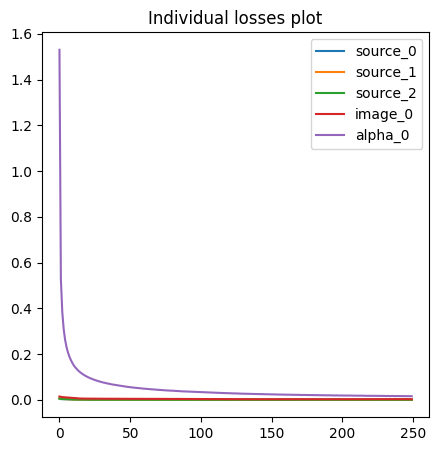

In [10]:
plot, axes = plt.subplots(1,1)
plot.set_size_inches(5,5)
for key in list(individual_losses.keys()):
    axes.plot(history_losses[key],label=key)
axes.legend()
axes.set_title('Individual losses plot')

Text(0.5, 1.0, 'Train and val losses')

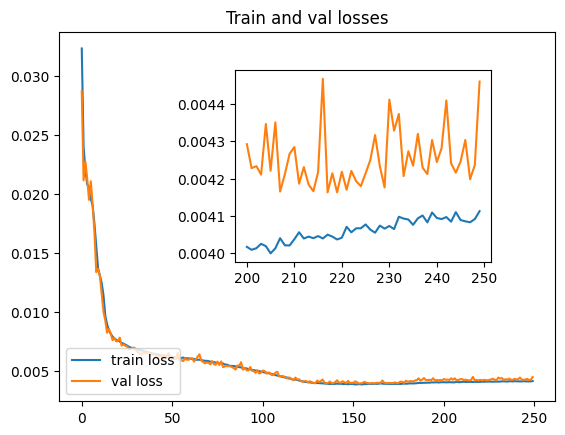

In [11]:
plot, axes = plt.subplots()
axes.plot(history['loss'],label='train loss')
axes.plot(history['val_loss'],label='val loss')
axes_2 = plot.add_axes([0.4,0.4,0.4,0.4])
axes_2.plot(range(int(0.8*len(history['loss'])),len(history['loss'])),history['loss'][int(0.8*len(history['loss'])):],label='train loss')
axes_2.plot(range(int(0.8*len(history['loss'])),len(history['loss'])),history['val_loss'][int(0.8*len(history['loss'])):],label='val loss')
# axes_2.set_xticks([int(0.8*EPOCHS), EPOCHS])
axes.legend(loc='lower left')
axes.set_title('Train and val losses')

### Loading the best performing model

In [12]:
# Loads the model weights at the lowest validation score

alpha_model.load_state_dict(best_weights)
print(best_val_loss)

0.01941917573704439


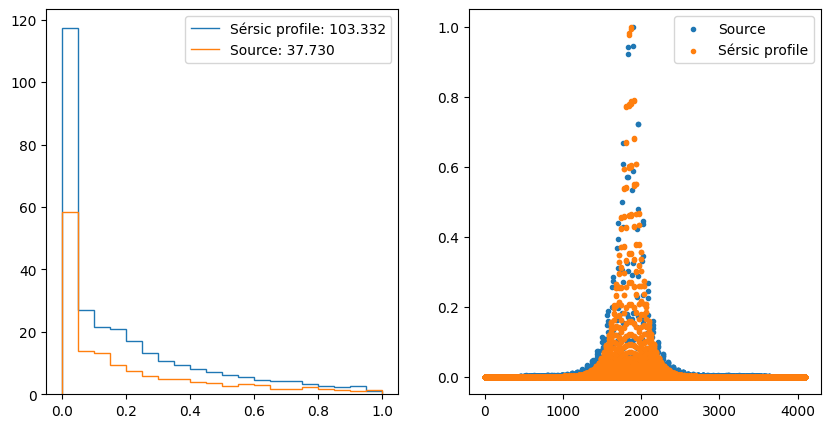

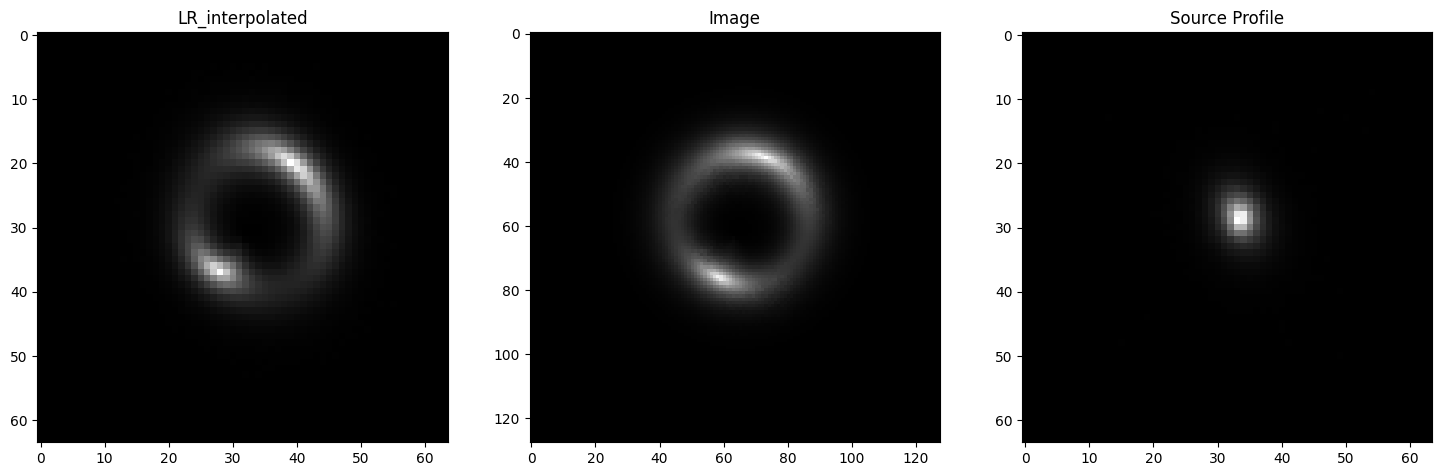

In [17]:
show_random_image(give_random_image(val_dataset, alpha_model, len(val_dataset)))

In [14]:
# Saves the training progress as GIFs of the reconstructed source and the super-resolved images

history['images'][0].save('images.gif',save_all=True, append_images = history['images'][1:], optimize=False, duration=100, loop=0)
history['lr'][0].save('lr.gif',save_all=True, append_images = history['lr'][1:], optimize=False, duration=100, loop=0)
history['source'][0].save('source.gif',save_all=True, append_images = history['source'][1:], optimize=False, duration=100, loop=0)

In [15]:
torch.save(best_weights, 'Weights_3.pt')